# Parallax Tutorial 01

This is the first tutorial notebook in the parallax series.  
In this tutorial notebook we will cover:
- The parallax operator
- Cross-correlation of virtual bright-field images
- Dose-efficiency of parallax imaging

### Downloads
This tutorial uses the following datasets:
- [parallax_apoferritin_simulation.h5](https://drive.google.com/file/d/1hr-fhseEr5XnWWVc4V6gNKXNYQwAoPez/view?usp=drive_link)

### Acknowledgements

This tutorial was created by the py4DSTEM `phase_contrast` team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Last updated: 2024 May 6

## Introduction

Parallax imaging, or tilt-corrected bright-field STEM is a phase retrieval method which attempts to reconstruct the scattering potential of an electron-transparent sample by utilizing the parallax phenomenon for a 4D-STEM dataset using a highly-defocused probe.

By reciprocity, a virtual image formed using a single pixel in the bright-field disk is equivalent to an image acquired using tilted-plane wave illumination. Averaging all these virtual images together gives an incoherent bright field (BF) image.

If instead these are aligned using the geometric parallax operator, the different geometric intercepts of the defocused probe can be corrected, resulting in a properly focused coherent image, known as a tilt-corrected BF image.

In [1]:
import numpy as np
import py4DSTEM
import matplotlib.pyplot as plt

print(py4DSTEM.__version__)

0.14.14


### Reciprocity Demonstration
We'll use the "infinite-dose" apoferritin dataset we simulated to demonstrate the statements above. A grid of 3x3 apoferritin particles is simulated at random rotations.

In [2]:
file_path = 'data/'
file_data = file_path + 'parallax_apoferritin_simulation.h5'

dataset_infinite = py4DSTEM.read(file_data)
dataset_infinite

DataCube( A 4-dimensional array of shape (73, 73, 128, 128) called 'datacube',
          with dimensions:

              Rx = [0.0,10.666666666666666,21.333333333333332,...] A
              Ry = [0.0,10.666666666666666,21.333333333333332,...] A
              Qx = [0.0,0.1538085070134974,0.3076170140269948,...] mrad
              Qy = [0.0,0.1538085070134974,0.3076170140269948,...] mrad
)

First, we'll compute the mean diffraction pattern, and binarize it to obtain the pixel indices inside our BF disk.

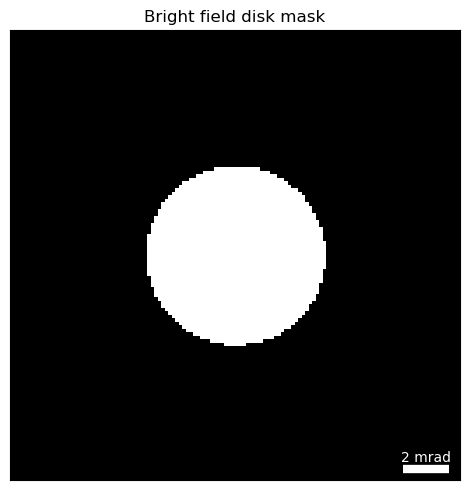

In [3]:
mean_diffraction_pattern = dataset_infinite.get_dp_mean().data
mean_diffraction_pattern /= mean_diffraction_pattern.max()
bright_field_mask = mean_diffraction_pattern > 0.5
bright_field_mask_indices_vertical, bright_field_mask_indices_horizontal = np.where(bright_field_mask)

reciprocal_sampling = dataset_infinite.calibration.get_Q_pixel_size()
reciprocal_units = dataset_infinite.calibration.get_Q_pixel_units()
reciprocal_kwargs = {"pixelsize":reciprocal_sampling,"pixelunits":reciprocal_units,"scalebar":True,"ticks":False}

py4DSTEM.show(
    bright_field_mask,
    **reciprocal_kwargs,
    title="Bright field disk mask",
)

If we sum all the pixels inside the BF disk, we recover an incoherent BF image. This is identical to a virtual bright field image you might ordinarily calculate with your datacube, perhaps with the `get_virtual_image` function.

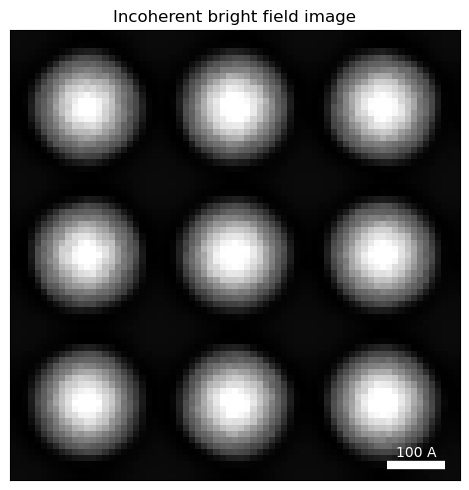

In [4]:
virtual_bright_field_images = dataset_infinite[:,:,bright_field_mask].transpose(2,0,1)

gridscan_sampling = dataset_infinite.calibration.get_R_pixel_size()
gridscan_units = dataset_infinite.calibration.get_R_pixel_units()
real_kwargs = {"pixelsize":gridscan_sampling,"pixelunits":gridscan_units,"scalebar":True,"ticks":False}

py4DSTEM.show(
    virtual_bright_field_images.sum(0),
    **real_kwargs,
    cmap='Greys',
    title="Incoherent bright field image",
)

Due to the infinite dose, we can clearly see the positions of our biological samples - but they are very blurred out due to the large defocus we used.  
Let's select a couple of these BF pixels and plot the tilted virtual images. To make the image shifts clearer, we will only plot the four apoferritin in the upper left corner. 

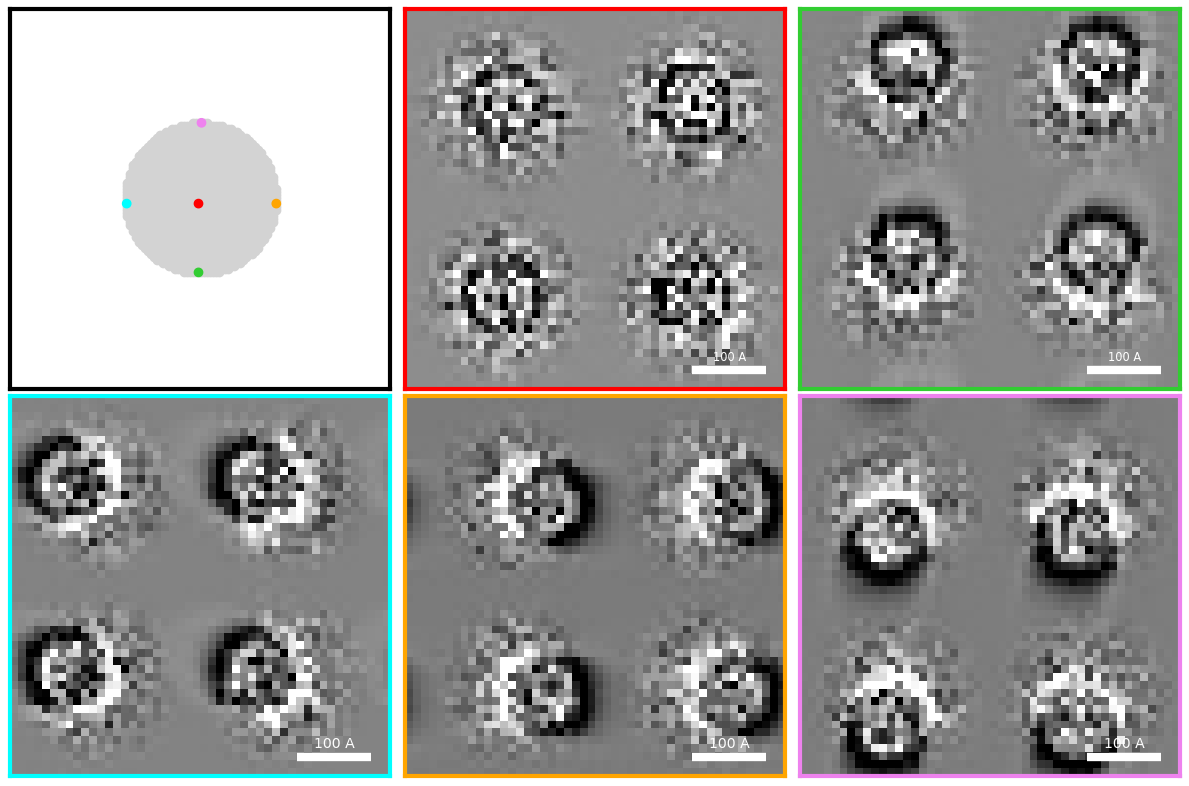

In [5]:
selected_indices = [
    934, # center
    5,   # bottom
    910, # left
    960, # right
    2040 # top
]
selected_colors = ['red','limegreen','cyan','orange', 'violet']

fig, axs = plt.subplots(2,3,figsize=(3*4,2*4))

axs[0,0].scatter(bright_field_mask_indices_horizontal,bright_field_mask_indices_vertical,c="lightgray")
axs[0,0].scatter(
    bright_field_mask_indices_horizontal[selected_indices],
    bright_field_mask_indices_vertical[selected_indices],
    c=selected_colors,
)
axs[0,0].set_aspect("equal"); axs[0,0].set_xticks([]) ;axs[0,0].set_yticks([])
axs[0,0].set_xlim([0,127]); axs[0,0].set_ylim([0,127]);
axs[0,0].spines[:].set_linewidth(3)

py4DSTEM.show(
    list(virtual_bright_field_images[selected_indices[:2],:48,:48]),
    figax=(fig,axs[0,1:]),
    **real_kwargs,
)

py4DSTEM.show(
    list(virtual_bright_field_images[selected_indices[2:],:48,:48]),
    figax=(fig,axs[1]),
    **real_kwargs,
)

for ax,color in zip(axs.flat[1:],selected_colors):
    ax.spines[:].set_color(color)
    ax.spines[:].set_linewidth(3)

fig.tight_layout()

The virtual BF images from pixels off the optic axis are noticeably shifted/tilted!

### Cross-correlation alignment

What parallax imaging does is cross-correlate all these virtual images to the optic axis.  
Let's see how this works for our ``infinite-dose`` dataset!

Alignment at bin 8: 100%|████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 245.29 image subsets/s]


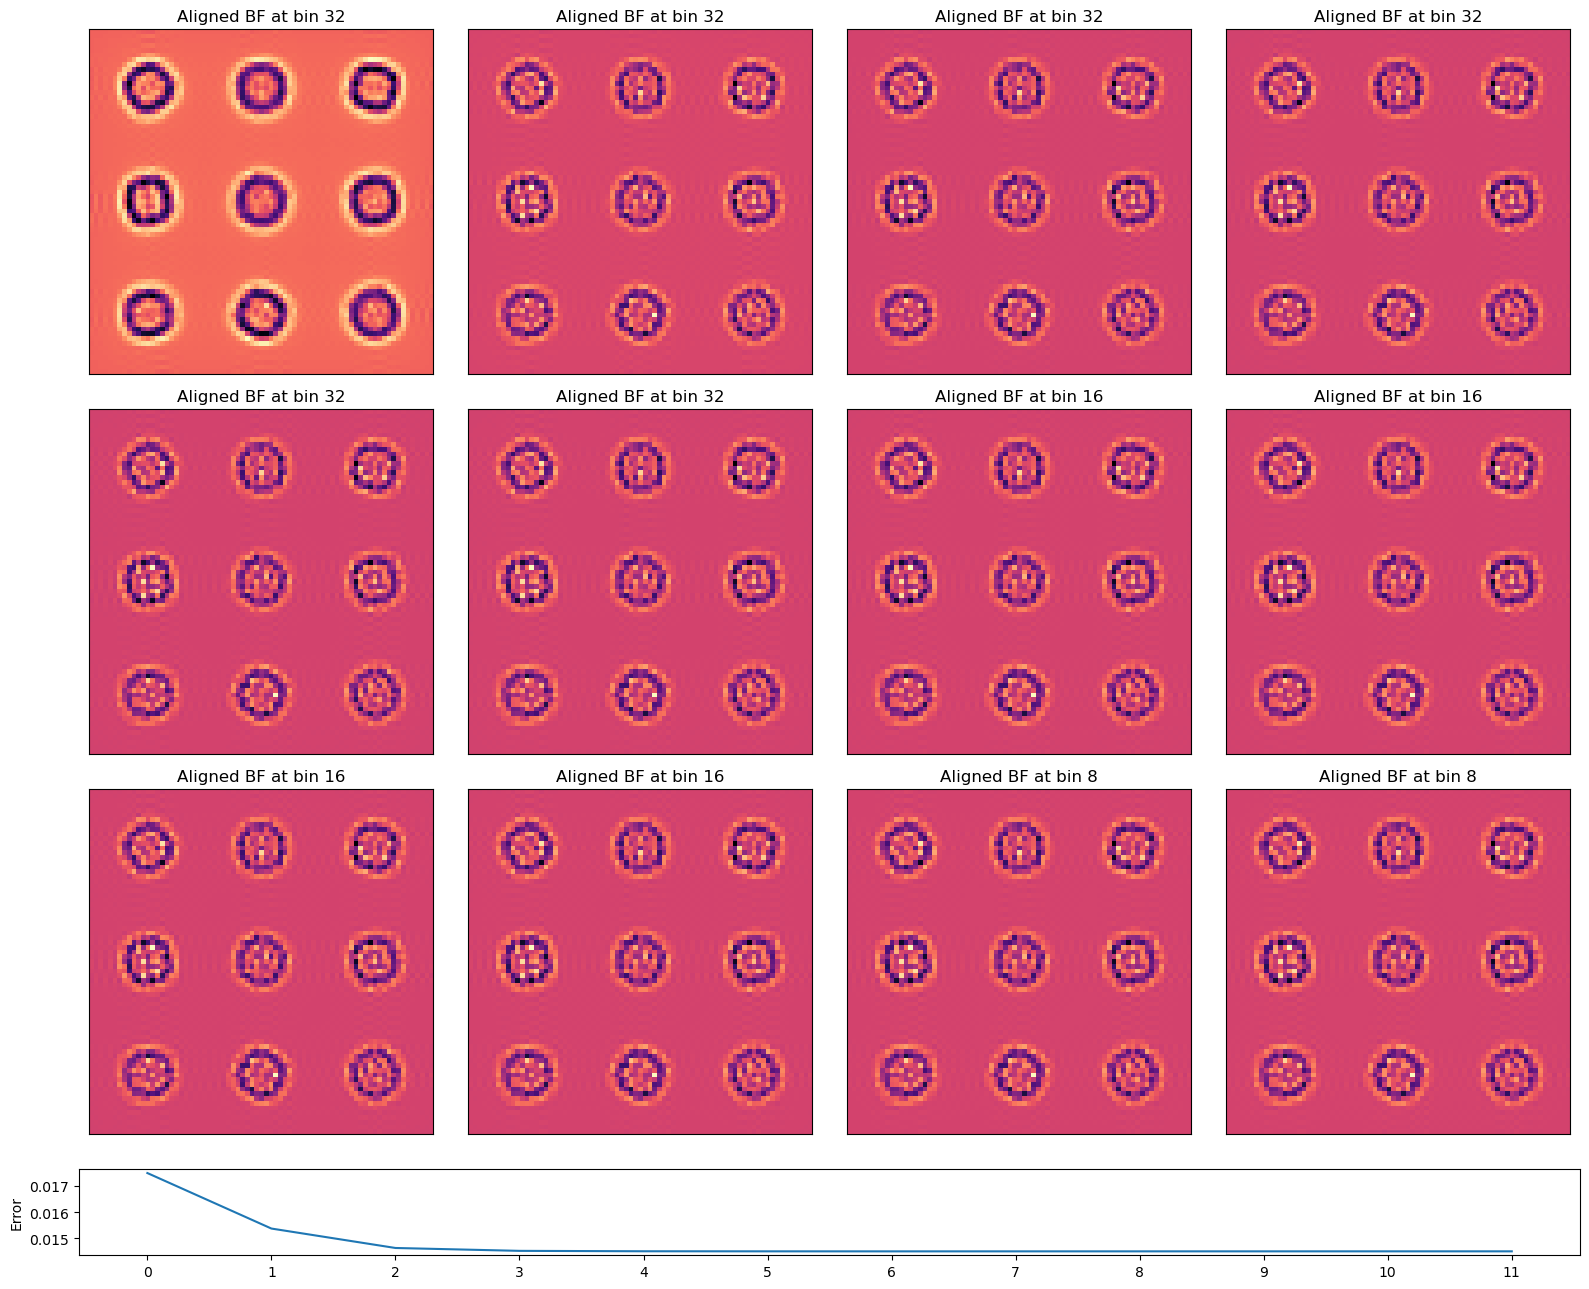

In [7]:
parallax = py4DSTEM.process.phase.Parallax(
    datacube=dataset_infinite,
    energy = 300e3,
    device = "cpu",
    object_padding_px=(16,16),
).preprocess(
    edge_blend=8,
    plot_average_bf=False,
).reconstruct(
    alignment_bin_values=[32,32,32,32,32,32,16,16,16,16,8,8],
)

The algorithm iteratively cross-correlates the virtual BF images of succesively binned datasets (to boost signal-to-noise), using the cross-correlation shifts at the previous bin as an initial guess.  
We can plot the cross-correlation vector at each virtual BF disk pixel location. Note this is an estimate of the aberration surface gradient.

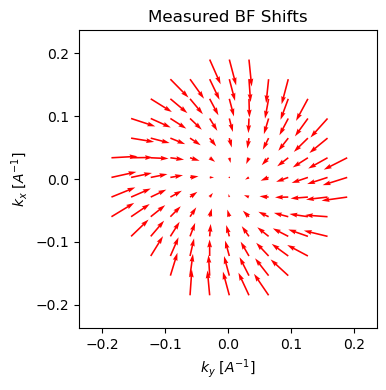

In [10]:
parallax.show_shifts(
    plot_arrow_freq=4, # plot every 4th arrow for clarity
)

The aligned virtual BF image, using these cross-correlation shifts, is considerably sharper than each individual virtual BF image!

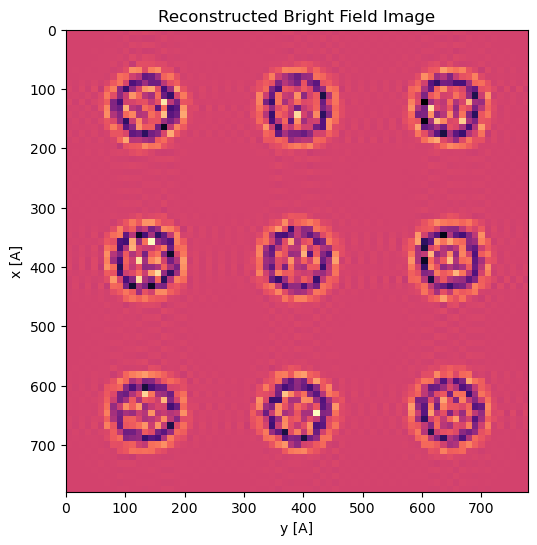

In [11]:
parallax = parallax.visualize()

### Finite dose

The cross-correlation above succeeded remarkably well, due to the infinite dose. In practice, we use a finite electron dose. Especially for biological samples, we can only use very few electrons before we start damaging our sample.

In what follows, we apply various finite Poisson dose of various amounts to our simulations to see how parallax works under more realistic conditions.

In [12]:
np.random.seed(1234)
area_per_probe = gridscan_sampling**2

dataset_finite_50 = dataset_infinite.copy()
dataset_finite_50.data = np.random.poisson((dataset_infinite.data * 50 * area_per_probe).clip(0)).astype(np.uint64)

dataset_finite_100 = dataset_infinite.copy()
dataset_finite_100.data = np.random.poisson((dataset_infinite.data * 100 * area_per_probe).clip(0)).astype(np.uint64)

dataset_finite_10 = dataset_infinite.copy()
dataset_finite_10.data = np.random.poisson((dataset_infinite.data * 10 * area_per_probe).clip(0)).astype(np.uint64)

First, let's see how noisy the diffraction patterns look!

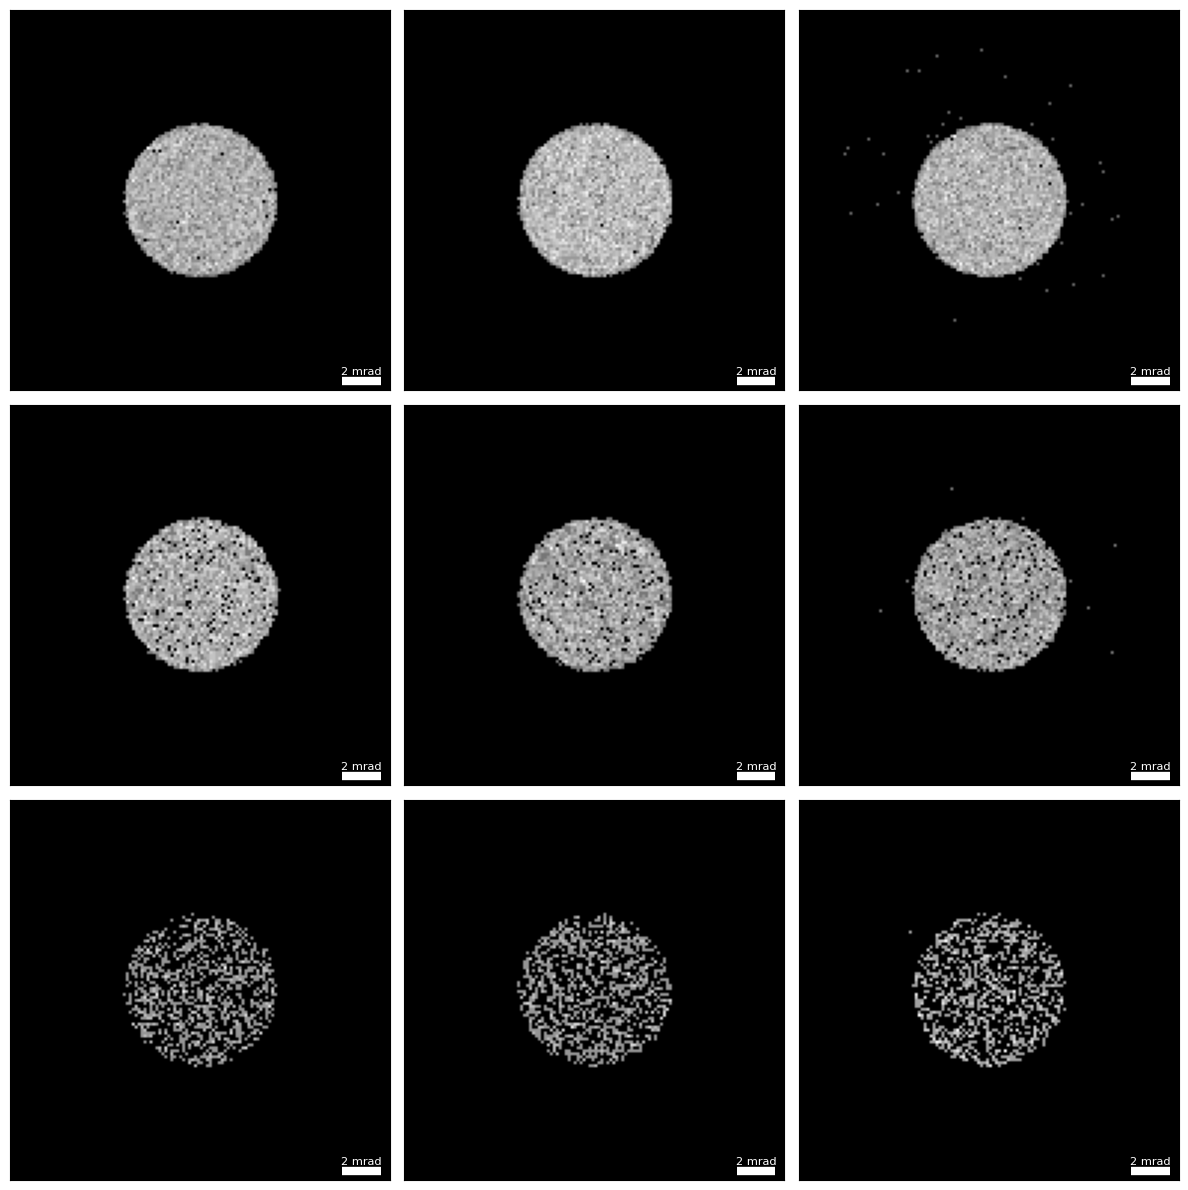

In [13]:
py4DSTEM.show(
    [
        [
            dataset_finite_100[11,24],
            dataset_finite_100[18,24],
            dataset_finite_100[11,12],
        ],
        [
            dataset_finite_50[11,24],
            dataset_finite_50[18,24],
            dataset_finite_50[11,12],
        ],
        [
            dataset_finite_10[11,24],
            dataset_finite_10[18,24],
            dataset_finite_10[11,12],
        ],
    ],
    vmax=1,
    power=0.333,
    axsize=(4,4),
    **reciprocal_kwargs
)

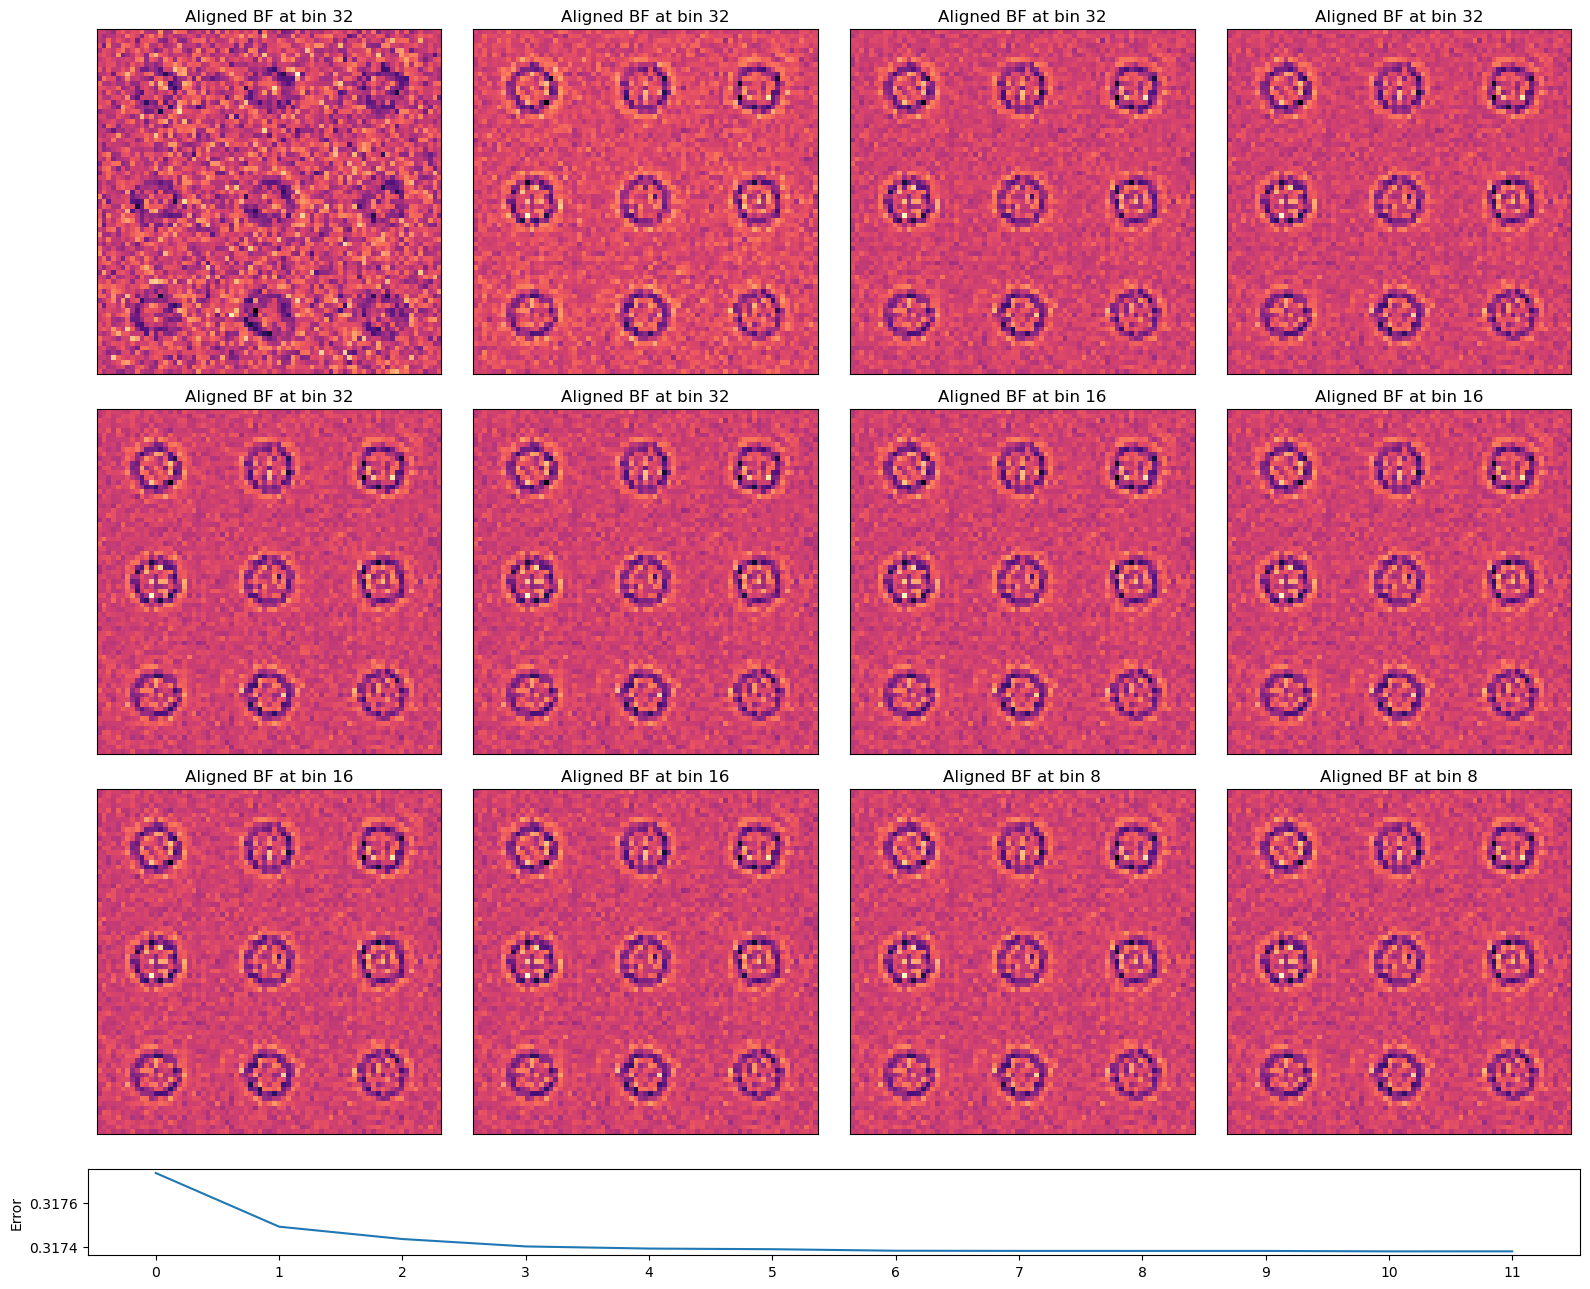

In [14]:
parallax_finite_100 = py4DSTEM.process.phase.Parallax(
    datacube=dataset_finite_100,
    energy = 300e3,
    device = "cpu",
    object_padding_px=(16,16),
).preprocess(
    edge_blend=8,
    plot_average_bf=False,
).reconstruct(
    alignment_bin_values=[32,32,32,32,32,32,16,16,16,16,8,8],
    regularize_shifts=False,
    progress_bar=False,
)

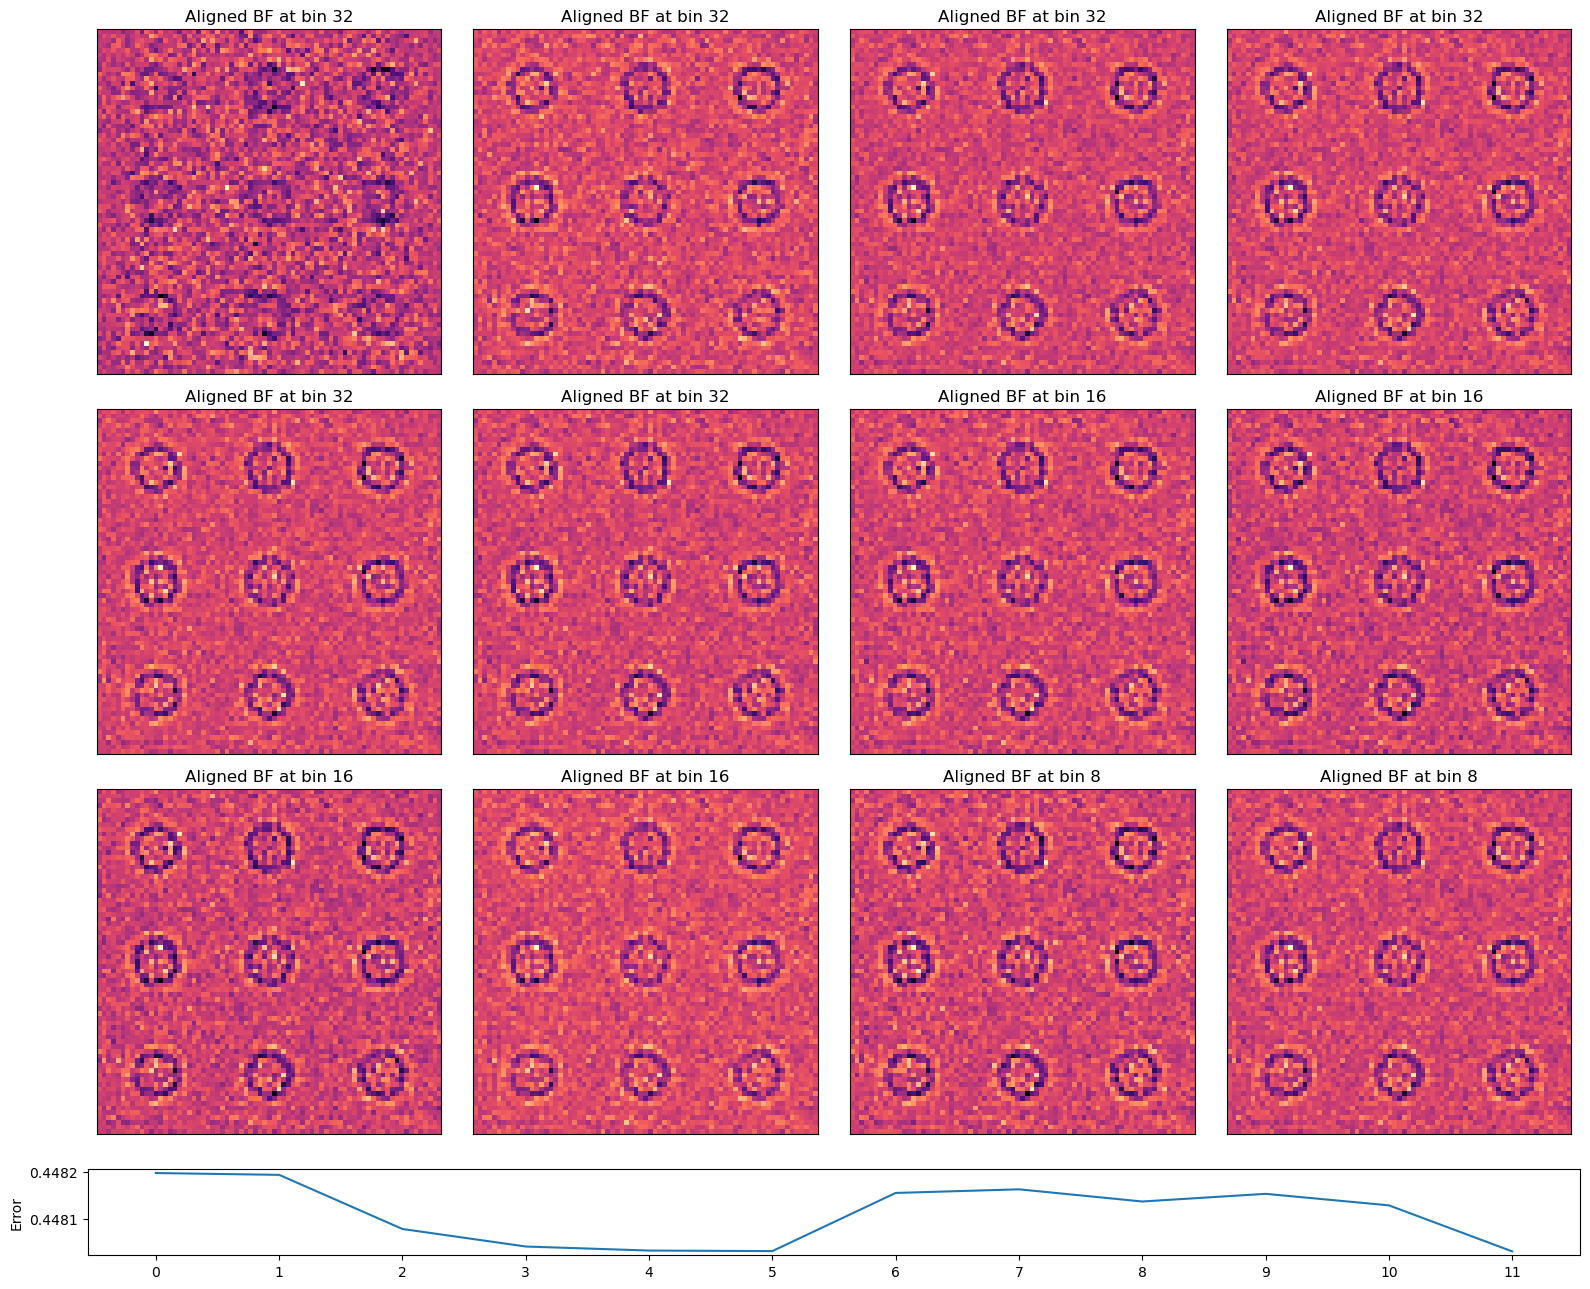

In [15]:
parallax_finite_50 = py4DSTEM.process.phase.Parallax(
    datacube=dataset_finite_50,
    energy = 300e3,
    device = "cpu",
    object_padding_px=(16,16),
).preprocess(
    edge_blend=8,
    plot_average_bf=False,
).reconstruct(
    alignment_bin_values=[32,32,32,32,32,32,16,16,16,16,8,8],
    regularize_shifts=False,
    progress_bar=False,
)

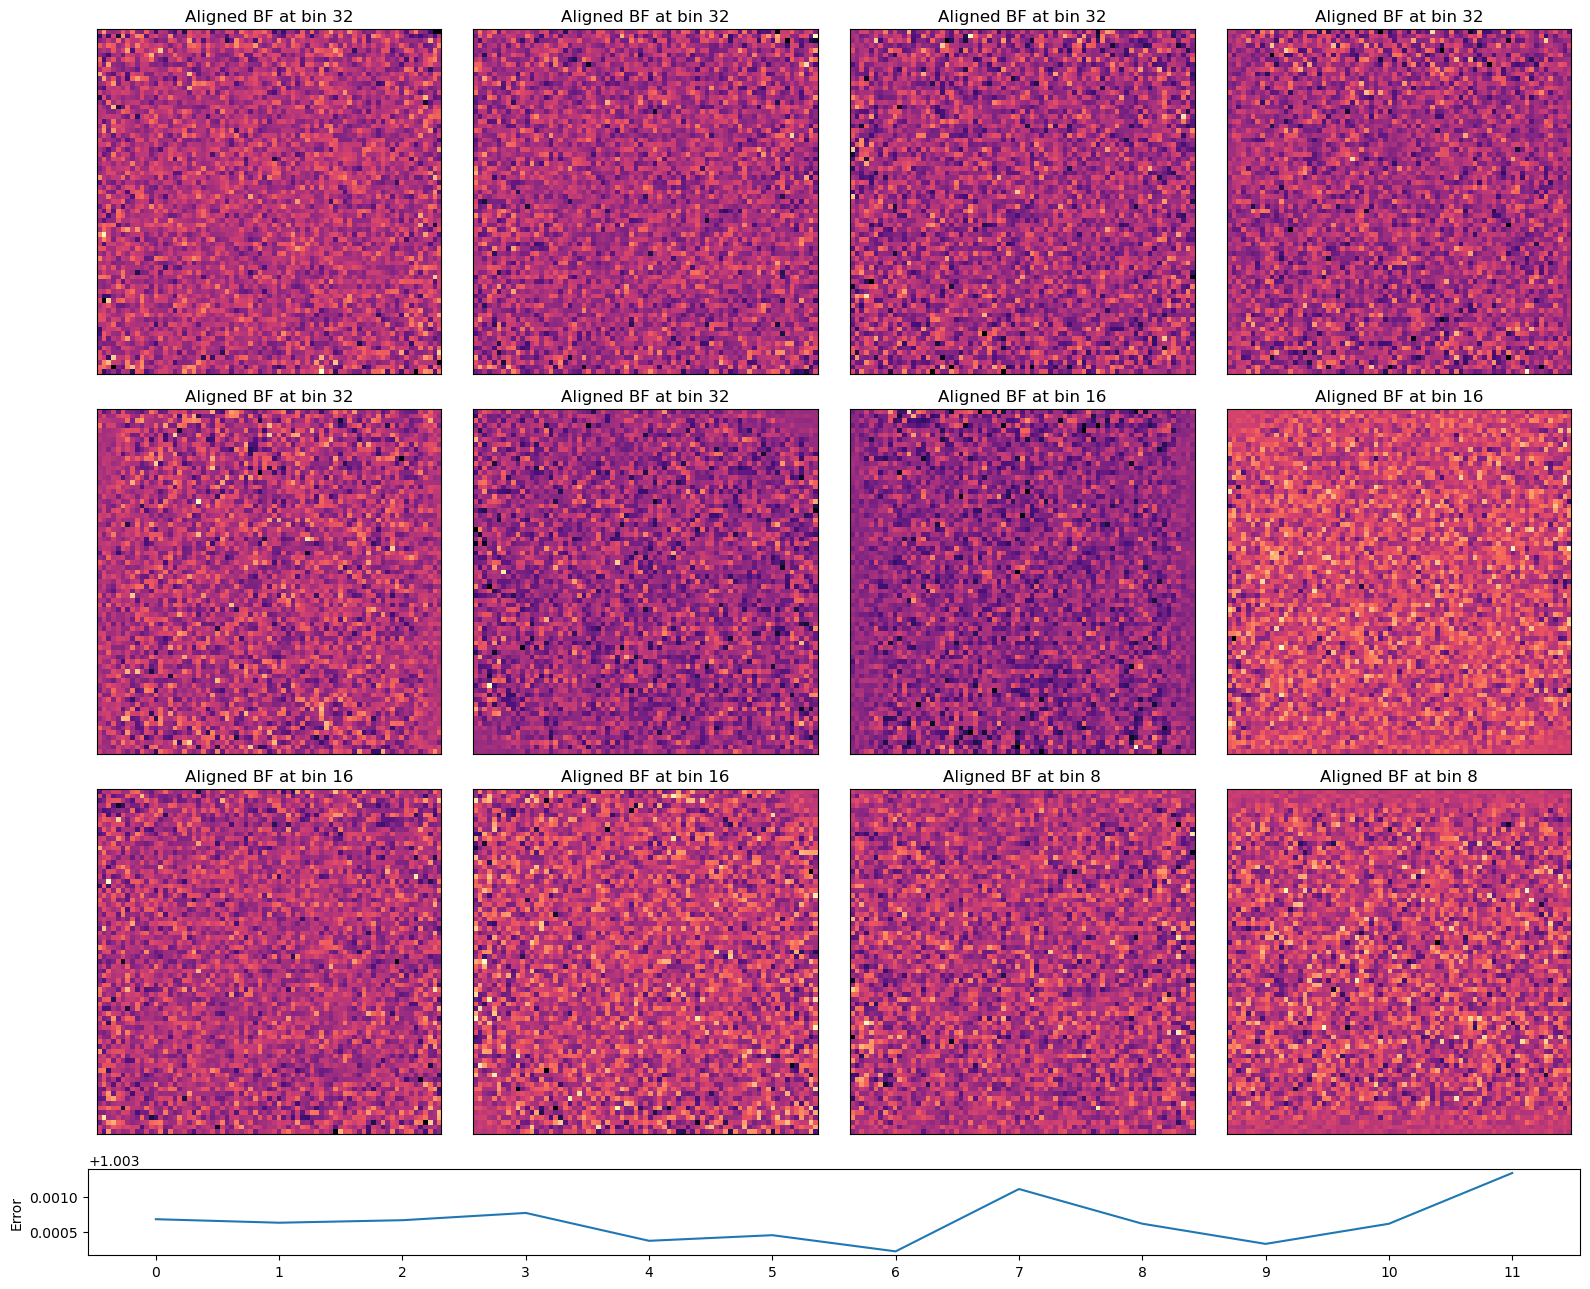

In [23]:
parallax_finite_10 = py4DSTEM.process.phase.Parallax(
    datacube=dataset_finite_10,
    energy = 300e3,
    device = "cpu",
    object_padding_px=(16,16),
).preprocess(
    edge_blend=8,
    plot_average_bf=False,
).reconstruct(
    alignment_bin_values=[32,32,32,32,32,32,16,16,16,16,8,8],
    regularize_shifts=False,
    progress_bar=False,
)

Let's compare the final aligned BF images. It's evident that as the dataset (and thus the virtual BFs) become noisier, the cross-correlation alignment struggles to find features to align to.  
In practice, we often overcome this by sprinkling highly-scattering fiducial markers (like gold nanoparticles) in the field of view!

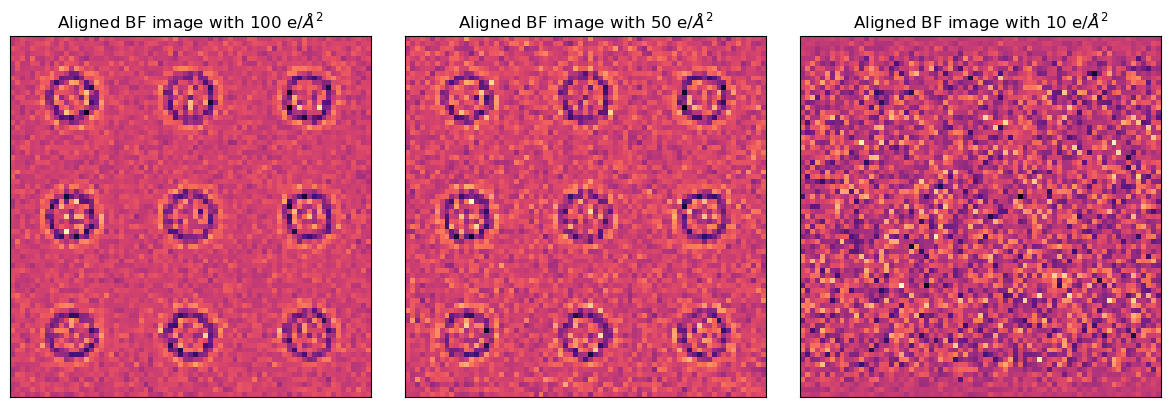

In [24]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
for par, ax, dose in zip([parallax_finite_100,parallax_finite_50,parallax_finite_10],axs, [100,50,10]):
    par._visualize_figax(fig,ax)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f"Aligned BF image with {dose} e/$\AA^2$")

fig.tight_layout()